# A three-body problem with stable orbits

This notebook shows one stable solution to the three-body problem. In this case, the three particles all follow the same figure-8 orbit.

Packages needed are NumPy and Matplotlib. 

For the last bit, SciPy is used, as well as the Matplotlib-Jupyter extension (`ipympl`).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Set up the variables

Define a State class that keeps track of four parameters, x, y, u and v. It has the special properties that adding two states will add the individual parameters, while multiplying a state by a float will multiply the individual parameters by that float.

In [2]:
class State:
    """Generic class to hold four variables: x & y and their derivates
    
    The State's addition and multiplication behaves similar to a NumPy array:
    addition is by individual attributes, while multiplication by a number 
    is done like broadcasting. This makes State very similar to a 
    1-element NumPy recarray, or a Pandas dataframe row; but using 
    those structures would have the overhead of memory allocation each time
    it is created.
    
    """

    def __init__(self, x=0, y=0, u=0, v=0):
        self.x = x
        self.y = y
        self.u = u
        self.v = v
        self._vars = ['x', 'y', 'u', 'v']  # Used for repr, str and repr_html
        
    def __add__(self, other):
        """Addition by members"""
        return self.__class__(self.x + other.x, self.y + other.y, self.u + other.u, self.v + other.v)

    def __sub__(self, other):
        """Subtraction by members"""
        return self.__class__(self.x - other.x, self.y - other.y, self.u - other.u, self.v - other.v)

    def __mul__(self, other):
        """Multiplication by a single number"""
        return self.__class__(self.x * other, self.y * other, self.u * other, self.v * other)

    def __rmul__(self, other):
        """Multiplication of a single number by a State"""
        return self.__mul__(other)

    def __repr__(self):
        return f"State({self.x}, {self.y}, {self.u}, {self.v})"
        
    def __str__(self):
        return f"{self.x:10.6f} {self.y:10.6f} {self.u:10.6f} {self.v:10.6f}"

    def _repr_html_(self):
        """Produce nicer notebook output"""
        return f"""
<dl>
<dt>x</dt>
<dd>{self.x:10.6f}</dd>
<dt>y</dt>
<dd>{self.y:10.6f}</dd>
<dt>u</dt>
<dd>{self.y:10.6f}</dd>
<dt>v</dt>
<dd>{self.v:10.6f}</dd>
</dl>
"""

In [3]:
state = State(1, 2, 3, 4)
state + state * 1.5

State(2.5, 5.0, 7.5, 10.0)

A `Particle` wraps a `State` (also known as composition), plus a mass. 

Alternatively, we could have a `Particle` inherit from `State`.

Composition can make things a bit more verbose, but is more explicit; you now have to use `Particle(1, State(3, 4)); particle.state.x` versus `Particle(1, 3, 4); particle.x`.

In [4]:
class Particle:
    def __init__(self, m, state):
        self.m = m
        self.state = state

    def __add__(self, other):
        """Addition by another Particle or State"""
        # Only add masses if `other` is a particle
        if isinstance(other, Particle):
            m = self.m + other.m
            state = self.state + other.state
        else:
            m = self.m
            state = self.state + other
        return self.__class__(m, state)

    def __repr__(self):
        return f"Particle({self.m}, {self.state!r})"
        
    def __str__(self):
        return f"{self.m:.3f}; {self.state}"

    def _repr_html_(self):
        """Produce nicer notebook output"""
        return f"""
<dl>
<dt>m</dt>
<dd>{self.m:.3f}</dd>
{self.state._repr_html_()}
</dl>
"""

In [5]:
class ParticleOld(State):
    """Class to present a particle, with its mass, its trajectory and velocity over time"""

    def __init__(self, m=1, x=0, y=0, u=0, v=0):
        self.m = m
        super().__init__(x, y, u, v)
        self._vars = ['m'] + self._vars

    # Need to override `__add__`, for the case of adding two particles together
    def __add__(self, other):
        """Addition by other Particles or States"""
        # Only add masses if `other` is a particle
        m = self.m + other.m if isinstance(other, Particle) else self.m
        return self.__class__(m, self.x + other.x, self.y + other.y, self.u + other.u, self.v + other.v)



In [6]:
particle1, particle2 = Particle(10, State(1, 2)), Particle(5, State(3, 4))
particle1 + particle2

Particle(15, State(4, 6, 0, 0))

In [7]:
state = State(5, 6)
particle1 + state

Particle(10, State(6, 8, 0, 0))

Finally a `System` contains a list of a list of particles. The outer list of particles are all the time steps, while the inner list are the individual particles.

A `System` also contains other properties pertaining to the, well, system; here only `G`, the gravitational constant, is set (normalized to 1 by default).

In [8]:
from itertools import combinations

class System:
    
    """A system of particles, with specified physical parameters 
    
    The system contains particles, for multiple time steps.     
    Thus `self.particles` is a list (time) of a list (number) of Particles.

    """
    def __init__(self, particles, G=1):
        # self.particles is a list of a list of Particles
        self.particles = [particles]
        self.time = [0]
        
        # The System's Universe constants
        self.G = G
        
    def center_of_mass(self, n):
        """return the center of mass of the system at timestep n"""

        particles = self.particles[n]
        mass_x = sum(particle.m * particle.state.x for particle in particles)
        mass_y = sum(particle.m * particle.state.y for particle in particles)
        mass_total = sum(particle.m for particle in particles)
        mass_x /= mass_total
        mass_y /= mass_total

        return mass_x, mass_y


    def energy(self, n):
        """return the energy of the system at timestep n"""

        particles = self.particles[n]
    
        # kinetic energy
        ke = sum(0.5 * particle.m * (particle.state.u**2 + particle.state.v**2)
                 for particle in particles)

        # potential energy
        # `itertools.combinations` gets all the pairs, without duplication
        pe = sum(-self.G * particle1.m * particle2.m /
                     ((particle1.state.x - particle2.state.x)**2 +
                      (particle1.state.y - particle2.state.y)**2)**0.5
                 for particle1, particle2 in combinations(particles, 2))

        return ke + pe

Create the stable system of particles, and calculate the energy and center of mass. Since there is no simulation done yet, only time step 0 is available.

In [19]:
particles0 = [
    Particle(1, State(-0.97000436, 0.24308753, 0.4662036850, 0.4323657300)), 
    Particle(1, State(0, 0, -0.93240737, -0.86473146)),
    Particle(1, State(0.97000436, -0.24308753, 0.4662036850, 0.4323657300)),
]
system = System(particles0)
system.particles

[[Particle(1, State(-0.97000436, 0.24308753, 0.466203685, 0.43236573)),
  Particle(1, State(0, 0, -0.93240737, -0.86473146)),
  Particle(1, State(0.97000436, -0.24308753, 0.466203685, 0.43236573))]]

In [20]:
system.energy(0), system.center_of_mass(0)

(-1.2871419917663258, (0.0, 0.0))

## Defining the actual functions

Define the gravitational interaction between the particles.

This returns the derivatives for each particle, each set of derivatives packed together in a `State`.

In [21]:
SMALL = 1e-30  # Fudge factor to prevent division by zero when two particles collide

def gravitate(particles, G=1):
    """Calculate the gravitational interacting between particles 
    and return the relevant derivatives"""

    derivs = []

    for particle1 in particles:

        # compute the space derivatives
        dxdt = particle1.state.u
        dydt = particle1.state.v

        # compute the velocity derivatives
        dudt = 0.0
        dvdt = 0.0

        for particle2 in particles:
            if id(particle1) == id(particle2):
                continue
                
            dx = particle2.state.x - particle1.state.x
            dy = particle2.state.y - particle1.state.y
            r = dx**2 + dy**2
            r = np.sqrt(r) + SMALL
            dudt += G * particle2.m * dx / r**3
            dvdt += G * particle2.m * dy / r**3

        derivs.append(State(dxdt, dydt, dudt, dvdt))

    return derivs

Perform a Runge-Kutta step.

Here it is convenient that we can add a `Particle` and a `State`, as well as multiply a `State` by a float (`dt` or `0.5 * dt`).

In [22]:
def step(particles, dt, func):
    """Take a single RK-4 timestep from t_n to t_n+`dt` for a set of `particles` interacting in `func`"""

    # Update the derivatives
    derivs1 = func(particles)

    # Progress by half a time step
    tempparticles = [particle + 0.5 * dt * deriv for particle, deriv in zip(particles, derivs1)]
    
    # Update the derivatives by half a time step
    derivs2 = func(tempparticles)
    
    # Progress again by half a time step from the start, with new derivatives
    tempparticles = [particle + 0.5 * dt * deriv for particle, deriv in zip(particles, derivs2)]

    # Calculate the new derivatives with the second result
    derivs3 = func(tempparticles)

    # Proceed a full time step with the new results
    tempparticles = [particle + dt * deriv for particle, deriv in zip(particles, derivs3)]

    derivs4 = func(tempparticles)

    # Now do a fully averaged step with all the calculated derivates
    particles = [particle + dt/6 * (deriv1 + 2 * deriv2 + 2 * deriv3 + deriv4)
                 for particle, deriv1, deriv2, deriv3, deriv4 in zip(particles, derivs1, derivs2, derivs3, derivs4)]

    return particles

Perform a short trial step

In [23]:
from functools import partial

func = partial(gravitate, G=system.G)   # `partial` allows us to turn `gravitate` into a one-argument function with set `G`
step(system.particles[0], 0.01, func)

[Particle(1, State(-0.9652814261763859, 0.24739564732006566, 0.4784102224189193, 0.42922260367933)),
 Particle(1, State(-0.00932461753533751, -0.008646629051407366, -0.9325705089756273, -0.8645257837126548)),
 Particle(1, State(0.9746060437117234, -0.2387490182686583, 0.4541602865567081, 0.4353031800333247))]

Set up the main integration loop.

An inner loop takes care of ensuring the relative error is smaller than or equal to our error criterion.

In [30]:
from itertools import chain


def integrate(system, dt, criterion, tmax):
    """ integrate the equations of motion using 4th order R-K
    method with an adaptive stepsize, to try to achieve the
    relative error err.  dt here is the initial timestep

    """

    # safety parameters, from Garcia 2017
    S1 = 0.9
    S2 = 4.0

    # initial conditions
    t = 0.0

    # start with the old timestep
    dt_new = dt

    # number of function evaluations
    neval = 0

    while t < tmax:

        particles = system.particles[-1]

        error = 1.e10
        # Loop until `criterion` is reached
        while error > criterion:
            dt = dt_new
            if t + dt > tmax:
                dt = tmax - t

            # take 2 half steps
            particles = step(system.particles[-1], 0.5*dt, gravitate)
            two_step_particles = step(particles, 0.5*dt, gravitate)
            # A single step is 4 function evaluations
            neval += 8
            
            # now take just a single step to cover dt
            one_step_particles = step(system.particles[-1], dt, gravitate)
            neval += 4

            # two_step_particles should be more accurate one_step_particles,
            # since it used smaller steps.
            print(list(chain.from_iterable([
                [abs((particle1.state.x - particle2.state.x) / particle1.state.x), 
                 abs((particle1.state.y - particle2.state.y) / particle1.state.y),
                 abs((particle1.state.u - particle2.state.u) / particle1.state.u),
                 abs((particle1.state.v - particle2.state.v) / particle1.state.v)]
                for particle1, particle2 in zip(one_step_particles, two_step_particles)])))
            return
            # estimate the maximum relative error
            error = max(chain.from_iterable([
                [abs((particle1.state.x - particle2.state.x) / particle1.state.x), 
                 abs((particle1.state.y - particle2.state.y) / particle1.state.y),
                 abs((particle1.state.u - particle2.state.u) / particle1.state.u),
                 abs((particle1.state.v - particle2.state.v) / particle1.state.v)]
                for particle1, particle2 in zip(one_step_particles, two_step_particles)]))
            
            # adaptive timestep algorithm from Garcia (Eqs. 3.30 and 3.31)
            dt_est = dt * abs(criterion / error)**0.2
            low, high = dt / S2, dt * S2
            dt_new = min(max(S1*dt_est, low), high)

        # successful step
        t += dt

        # set for the next step
        system.time.append(t)
        system.particles.append(two_step_particles)

    return system, neval

Let's integrate for 6.5 seconds and with a loose error constraint.

In [31]:
integrate(system, 1e-2, 1e-2, 6.5)

[4.3291278518226805e-12, 8.795629100197993e-12, 4.7993030187425076e-11, 7.50744257071043e-11, 2.6250759616111477e-11, 9.308512212246266e-12, 1.6277907733297918e-11, 3.4932632440668926e-11, 1.1286811271958281e-12, 8.261569394017822e-12, 7.319124029155439e-11, 7.018623762099681e-12]


Extract the particle positions from their state

In [26]:
x1 = [particles[0].state.x for particles in system.particles]
x2 = [particles[1].state.x for particles in system.particles]
x3 = [particles[2].state.x for particles in system.particles]
y1 = [particles[0].state.y for particles in system.particles]
y2 = [particles[1].state.y for particles in system.particles]
y3 = [particles[2].state.y for particles in system.particles]

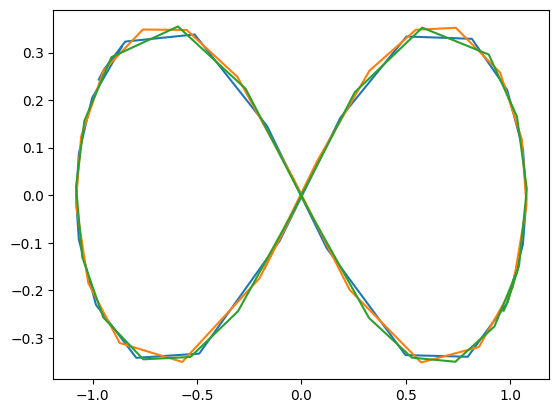

In [27]:
plt.figure()
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3);

Try again, with a tighter error constraint of 1e-6.

The result is much better, although the above figure suggests that even with the loose constraint, the orbits are reasonably stable.

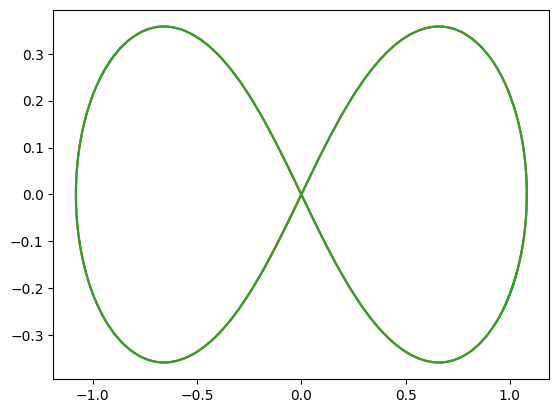

In [18]:
system = System(particles0)  # reset the system
integrate(system, 1e-2, 1e-6, 6.5)

x1 = [particles[0].state.x for particles in system.particles]
x2 = [particles[1].state.x for particles in system.particles]
x3 = [particles[2].state.x for particles in system.particles]
y1 = [particles[0].state.y for particles in system.particles]
y2 = [particles[1].state.y for particles in system.particles]
y3 = [particles[2].state.y for particles in system.particles]

plt.figure()
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3);

## Comparing with SciPy's ODE solver

SciPy's standard ODE solver is [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) 

(Older versions use `odeint`, which can still be used. The interface for `odeint` is slightly different than for `solve_ivp`, so pay attention if you're using `odeint` when used to `solve_ivp` (or vice versa)).

We'll need to rewrite the `gravitate` function that calculates the derivatives in a way that `solve_ivp` can handle. It's not too different, but input and output are all (one-dimensional) arrays now. To make things slightly easier, the input parameter `particles` (or simply `y` in `solve_ivp`'s documentation, whatever you'd like to call it. But hence the function name `dydt`) is transformed into a NumPy recarray, which makes handling it very similar to the `State` and `Particle` classes above.

In [19]:
def dydt(t, particles, m, G):
    """Calculate the gravitational interacting between particles 
    and return the relevant derivatives
    
    t: time

    particles: array of particles, each containing a
               position and velocity as .x, .y, .u and .v
               attributes
               
    """

    derivs = []

    # Reshape the input into a two dimensional array, with a particle per row
    # Then change the type to a recarray, with the columns the x, y, u and v parameters
    dtype = [('x', float), ('y', float), ('u', float), ('v', float)]
    particles = particles.reshape(-1, 4).view(dtype).view(np.recarray)
    
    for i, particle1 in enumerate(particles):

        # compute the space derivatives
        dxdt = particle1.u
        dydt = particle1.v

        # compute the velocity derivatives
        dudt = 0.0
        dvdt = 0.0

        for j, particle2 in enumerate(particles):
            if i == j:
                continue
                
            dx = particle2.x - particle1.x
            dy = particle2.y - particle1.y
            r = dx**2 + dy**2 + SMALL
            
            dudt += G * m[j] * dx / r**(3/2)
            dvdt += G * m[j] * dy / r**(3/2)

        derivs.extend([dxdt[0], dydt[0], dudt[0], dvdt[0]])

    return np.asarray(derivs)

In [20]:
m = [particle.m for particle in particles0]
y0 = [(particle.state.x, particle.state.y, particle.state.u, particle.state.v) for particle in particles0]
y0 = np.hstack(y0)
y0

array([-0.97000436,  0.24308753,  0.46620368,  0.43236573,  0.        ,
        0.        , -0.93240737, -0.86473146,  0.97000436, -0.24308753,
        0.46620368,  0.43236573])

In [21]:
from scipy.integrate import solve_ivp

sol = solve_ivp(dydt, [0, 6.5], y0[:], args=(m, system.G))   # `args` allow passing extra variables to `dydt`
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  2.481e-03 ...  6.263e+00  6.500e+00]
        y: [[-9.700e-01 -9.688e-01 ... -9.549e-01 -8.032e-01]
            [ 2.431e-01  2.442e-01 ...  2.332e-01  3.224e-01]
            ...
            [ 4.662e-01  4.632e-01 ...  4.544e-01  2.059e-01]
            [ 4.324e-01  4.331e-01 ...  4.356e-01  4.679e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 188
     njev: 0
      nlu: 0

Let's plot this.

The data are in `sol.y`, with three sets of x, y u and v data. So every group of four items along the first axis contains the x, y, u and v values of a single particle, with the second axis containing the actual data for the relevant parameter.

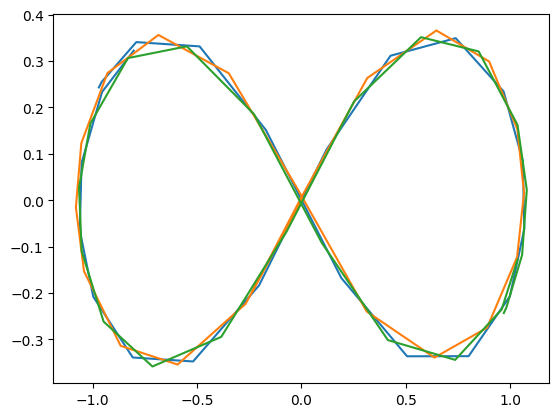

In [22]:
plt.figure()
plt.plot(sol.y[0], sol.y[1])
plt.plot(sol.y[4], sol.y[5])
plt.plot(sol.y[8], sol.y[9]);

That doesn't look too great, although it might just be the plotting resolution: the orbits do seem to overlap and stay stable.
How many data points are actually there?

In [23]:
len(sol.t)

24

`solve_ivp` with its default method of `RK45` only needed 24 points. As the solution output above shows, there were a total of 188 function evaluations, which is likely the more important number (especially when function evaluations are costly).

We can tweak various parameters, see the documentation on [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp).

Instead, let's try another method:

In [24]:
sol = solve_ivp(dydt, [0, 6.5], y0[:], args=(m, system.G), method='LSODA')
sol, len(sol.t)

(  message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 0.000e+00  3.392e-05 ...  6.491e+00  6.500e+00]
         y: [[-9.700e-01 -9.700e-01 ... -8.843e-01 -8.779e-01]
             [ 2.431e-01  2.431e-01 ...  3.016e-01  3.049e-01]
             ...
             [ 4.662e-01  4.662e-01 ...  2.886e-01  2.795e-01]
             [ 4.324e-01  4.324e-01 ...  4.642e-01  4.649e-01]]
       sol: None
  t_events: None
  y_events: None
      nfev: 387
      njev: 11
       nlu: 11,
 143)

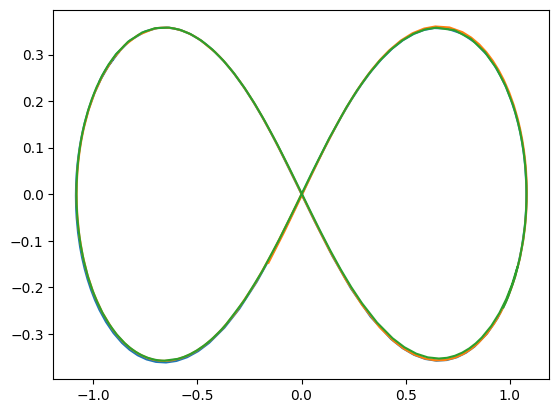

In [25]:
plt.figure()
plt.plot(sol.y[0], sol.y[1])
plt.plot(sol.y[4], sol.y[5])
plt.plot(sol.y[8], sol.y[9]);

There were more function evaluations, and more final data points overall with the LSODA method, which also results in a higher-resolution figure.

We can set the number of final data points using the `t_eval` parameter. Let's increase the timespan a bit, as well as the resolution.

In [26]:
sol = solve_ivp(dydt, [0, 16.5], y0[:], t_eval=np.linspace(0, 6.5, 500), args=(m, system.G), method='LSODA')
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.303e-02 ...  6.487e+00  6.500e+00]
        y: [[-9.700e-01 -9.638e-01 ... -8.867e-01 -8.779e-01]
            [ 2.431e-01  2.487e-01 ...  3.004e-01  3.049e-01]
            ...
            [ 4.662e-01  4.505e-01 ...  2.918e-01  2.793e-01]
            [ 4.324e-01  4.362e-01 ...  4.636e-01  4.645e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 955
     njev: 23
      nlu: 23

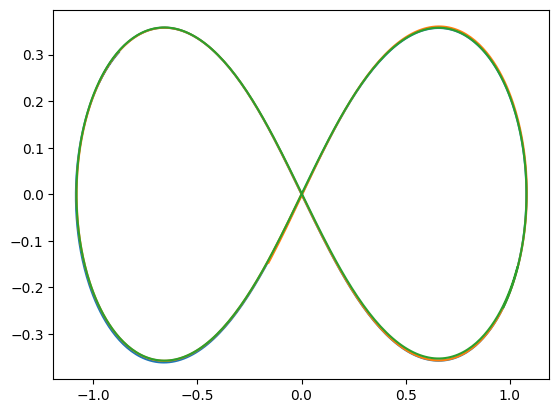

In [27]:
plt.figure()
plt.plot(sol.y[0], sol.y[1])
plt.plot(sol.y[4], sol.y[5])
plt.plot(sol.y[8], sol.y[9]);

# Animating the orbits

Note: for a Matplotlib animation to work in a notebook, you'll need to have the matplotlib-notebook extension installed (`ipympl`; I(nteractive)Python-matplotlib), to get interactive plots in a notebook. 

This can be done with
```
pip install ipympl
```
or comment out the cell below 
(if it doesn't immediately work, try restarting the notebook kernel).

In [28]:
#!pip install ipympl

Using Matplotlib's `FuncAnimation` to create an animation of the three orbits.

`FuncAnimation` calls a function that updates the relevant "artists" and returns an iterable of updated artists (the return value is necessary when `blit=True`, so the updates only get done when necessary). Note that there is a slight difference in updating the three line plots compared to updating the scatter plot.

To prevent `fig.add_subplot` drawing an empty plot early on, all code needs to live in a single cell. In addition, `FuncAnimation` requires its instantiation to be assigned to a variable (`anim`), so that it doesn't immediately gets garbage collected and the animation never shows.

The step of `::4` grabs the relevant parameter of each particle, with `x` having an offset of 0 and `y` having an offset of 1. To create a trail that disappears after a short while, we only draw the last 20 data points (using `max(0, i-20)` to prevent negative indices at the start).

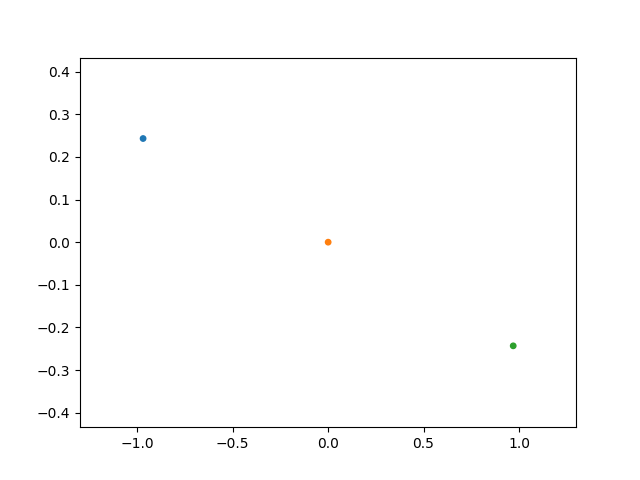

In [29]:
from matplotlib.animation import FuncAnimation

# or use %matplotlib widget ; both activate interactive plots
%matplotlib ipympl   

orbits = []
fig = plt.figure()
allx = np.hstack([sol.y[0], sol.y[4], sol.y[8]])
ally = np.hstack([sol.y[1], sol.y[5], sol.y[9]])
xlimits = min(allx), max(allx)
dx = xlimits[1] - xlimits[0]
xlimits = xlimits[0] - 0.1 * dx, xlimits[1] + 0.1 * dx
ylimits = min(ally), max(ally)
dy = ylimits[1] - ylimits[0]
ylimits = ylimits[0] - 0.1 * dy, ylimits[1] + 0.1 * dy
ax = fig.add_subplot(autoscale_on=False, xlim=xlimits, ylim=ylimits)

colors = []
for x, y in zip(sol.y[::4], sol.y[1::4]):
    orbit, = ax.plot([], [], '-')
    orbits.append(orbit)
    colors.append(orbit.get_color())
# Draw the single particles, with the same colors as the orbits
scatter = ax.scatter(sol.y[::4,0], sol.y[1::4,0], s=15, c=colors)

def animate(i):    
    for j, (x, y) in enumerate(zip(sol.y[::4], sol.y[1::4])):
        orbits[j].set_data(x[max(0, i-20):i], y[max(i-20, 0):i])
    points = np.vstack([[x[i] for x in sol.y[::4]], [y[i] for y in sol.y[1::4]]])
    scatter.set_offsets(points.T)
    return orbits + [scatter]

anim = FuncAnimation(
    fig, animate, len(sol.y[0]), interval=10, blit=True, repeat=False)

Now add the energy and center of mass. This time, use the hand-written solver results, not the solve_ivp's one.

In [30]:
system = System(particles0)  # reset the system
tmax = 1.5e1
integrate(system, 1e-2, 1e-6, tmax)

x1 = [particles[0].state.x for particles in system.particles]
x2 = [particles[1].state.x for particles in system.particles]
x3 = [particles[2].state.x for particles in system.particles]
y1 = [particles[0].state.y for particles in system.particles]
y2 = [particles[1].state.y for particles in system.particles]
y3 = [particles[2].state.y for particles in system.particles]

n = len(system.particles)
energies = [system.energy(i)for i in range(0, n)]
coms = [system.center_of_mass(i) for i in range(0, n)]

Perform the usual jiggery-pokery to set axes limits beforehand, with some whitespace on all sides.

In [31]:
allx = np.hstack([x1, x2, x3])
ally = np.hstack([y1, y2, y3])
xlimits = min(allx), max(allx)
dx = xlimits[1] - xlimits[0]
xlimits = xlimits[0] - 0.1 * dx, xlimits[1] + 0.1 * dx
ylimits = min(ally), max(ally)
dy = ylimits[1] - ylimits[0]
ylimits = ylimits[0] - 0.1 * dy, ylimits[1] + 0.1 * dy
tlimits = 0, tmax

timesteps = np.linspace(0, tmax, n)

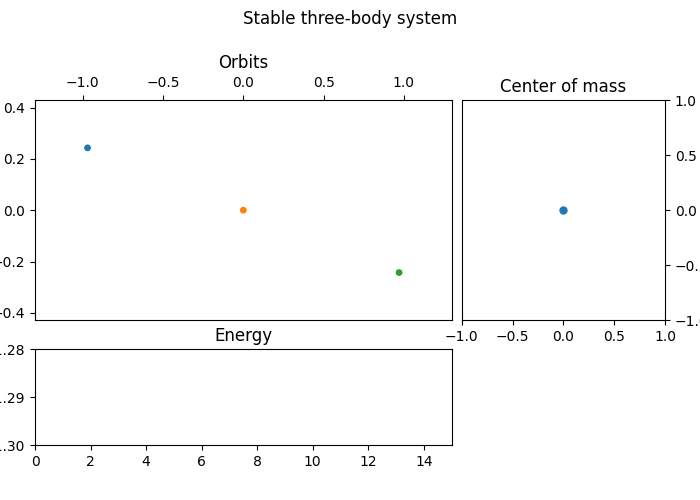

In [32]:
fig = plt.figure(figsize=(7, 5))
gs = fig.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.95, hspace=0.3, wspace=0.05)

orbits = []
#fig = plt.figure()

ax0 = fig.add_subplot(gs[:-1, :-1], xlim=xlimits, ylim=ylimits)
ax0.xaxis.tick_top()
ax1 = fig.add_subplot(gs[-1, :-1], xlim=tlimits, ylim=[-1.3, -1.28])
ax2 = fig.add_subplot(gs[:-1, -1], xlim=(-1, 1), ylim=(-1, 1))
ax2.yaxis.tick_right()
ax0.set_title('Orbits')
ax1.set_title('Energy')
ax2.set_title('Center of mass')
fig.subplots_adjust(top=0.8)  # shift things down a bit, to make space for the title
fig.suptitle('Stable three-body system', va='top')

colors = []
for _ in range(3):
    orbit, = ax0.plot([], [], '-')
    orbits.append(orbit)
    colors.append(orbit.get_color())
# Draw the single particles, with the same colors as the orbits
scatter = ax0.scatter([x1[0], x2[0], x3[0]], [y1[0], y2[0], y3[0]], s=15, c=colors)
energy, = ax1.plot([0.5, 0.9, 1.2], [0, 0, 0], '-')
com, = ax2.plot([coms[0][0]], [coms[0][1]], 'o', ms=5)
#print(coms)
def animate(i):    
    for j, (x, y) in enumerate(zip([x1, x2, x3], [y1, y2, y3])):
        orbits[j].set_data(x[max(0, i-20):i], y[max(i-20, 0):i])
    points = np.vstack([[x[i] for x in [x1, x2, x3]], [y[i] for y in [y1, y2, y3]]])
    scatter.set_offsets(points.T)
    energy.set_data(timesteps[:i], energies[:i])
    # Scale the center-of-mass positions by 1e12
    com.set_data([coms[i][0]*1e14], [coms[i][1]*1e14])
    return orbits + [scatter, energy, com]

anim = FuncAnimation(
    fig, animate, frames=len(x1), interval=10, blit=False, repeat=False)

The center of mass appears to drift a bit. Let's look how stable the system energy and center of mass are.

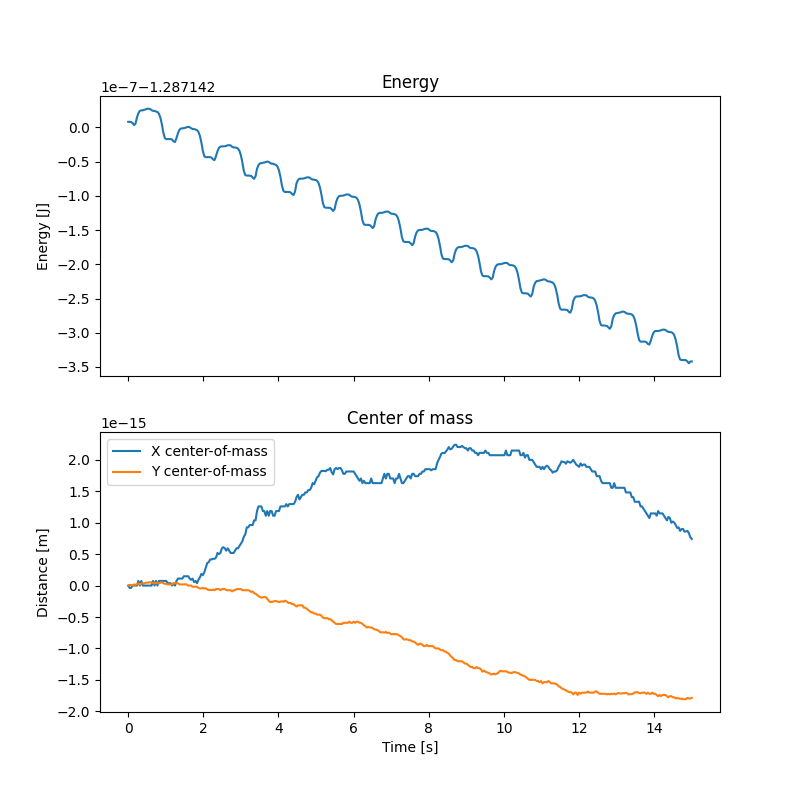

In [33]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
ax[0].plot(timesteps, energies, label='Energy')
ax[1].plot(timesteps, [x for x, _ in coms], label='X center-of-mass')
ax[1].plot(timesteps, [y for _, y in coms], label='Y center-of-mass')
ax[0].set_ylabel('Energy [J]')
ax[0].set_title('Energy')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Distance [m]')
ax[1].set_title('Center of mass')
ax[1].legend();

The energy is indeed not conserved, as was shown before for RK-4.

The drift in the center of mass is there, although the x-coordinate seems to move back to 0. Let's try once more with a stricter error criterion and a longer duration. 

In [51]:
%%time 

system = System(particles0)  # reset the system
tmax = 1.5e2
_, neval = integrate(system, 1e-2, 1e-8, tmax)

x1 = [particles[0].state.x for particles in system.particles]
x2 = [particles[1].state.x for particles in system.particles]
x3 = [particles[2].state.x for particles in system.particles]
y1 = [particles[0].state.y for particles in system.particles]
y2 = [particles[1].state.y for particles in system.particles]
y3 = [particles[2].state.y for particles in system.particles]

n = len(system.particles)
timesteps = np.linspace(0, tmax, n)
energies = [system.energy(i)for i in range(0, n)]
coms = [system.center_of_mass(i) for i in range(0, n)]
neval

CPU times: user 3.82 s, sys: 5.19 ms, total: 3.82 s
Wall time: 3.85 s


130752

So that's 286668 function evaluations and about 8 seconds of CPU time (Apple M1 Pro) for 150 seconds of simulation. Let's plot the orbits, energy and center-of-mass.

In [53]:
system.time[:20]

[0,
 0.01,
 0.02529649517949158,
 0.043728617799258546,
 0.06435249229921759,
 0.08676324247440219,
 0.11077609685640771,
 0.1350893923629591,
 0.15927918828327264,
 0.18340997996636216,
 0.20746525899221535,
 0.2311086800871346,
 0.25419690056539207,
 0.2765225015148741,
 0.29785911748606464,
 0.3180165551453893,
 0.33687655386168425,
 0.3543888626710329,
 0.37053852264041826,
 0.38530337354556715]

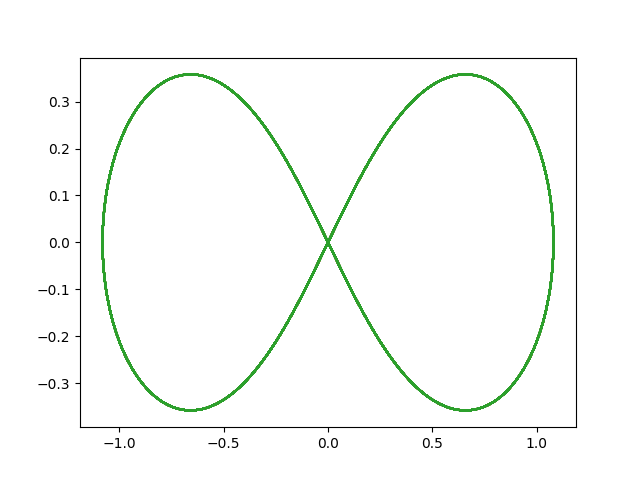

In [54]:
plt.figure()
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3);

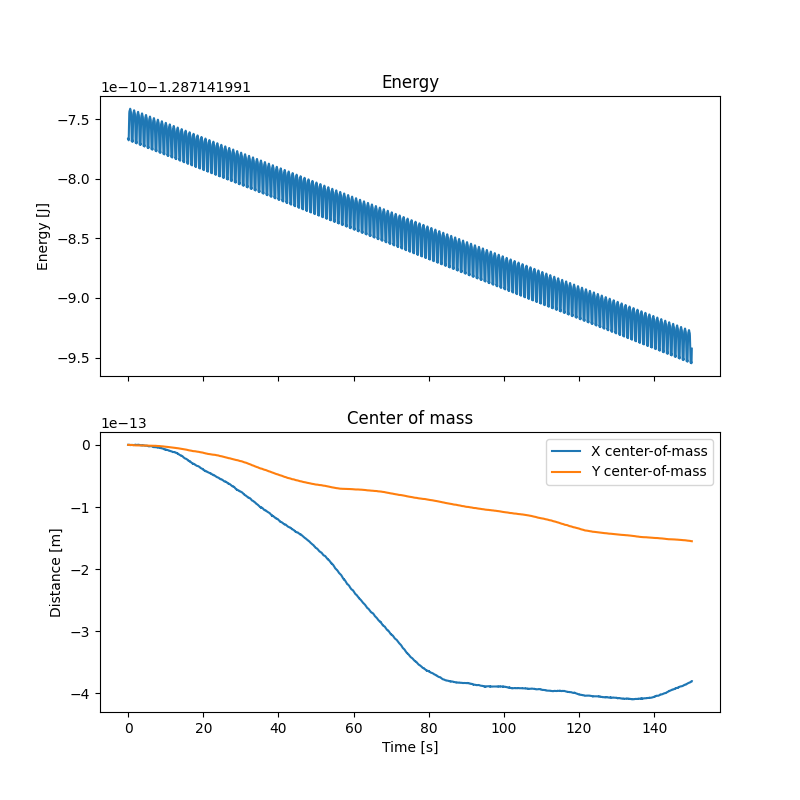

In [36]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
ax[0].plot(timesteps, energies, label='Energy')
ax[1].plot(timesteps, [x for x, _ in coms], label='X center-of-mass')
ax[1].plot(timesteps, [y for _, y in coms], label='Y center-of-mass')
ax[0].set_ylabel('Energy [J]')
ax[0].set_title('Energy')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Distance [m]')
ax[1].set_title('Center of mass')
ax[1].legend();

There is definitely a drift, as the system loses energy. The orbits themselves still look stable, on the scale we're looking at it.

One last comparison with SciPy's `solve_ivp`. In this case, One either needs to set `rtol=1e-10` as an argument, or change the (default) solver from `RK45` to `DOP853` (eight-order). The first variant, higher precision, requires significantly more function evaluations (and takes longer) than the default of `1e-3` with the `DOP853` solver.

Play around with the various parameters, such as `method`, `rtol` and `atol`, to get a feel for this. And compare the `RK45` method with `rtol` settings to the handwritten solver crafted above.

In [37]:
%%time

tmax = 150
sol = solve_ivp(dydt, [0, tmax], y0[:], t_eval=np.linspace(0, tmax, 1500), args=(m, system.G), method='DOP853')
sol

CPU times: user 1.44 s, sys: 6.36 ms, total: 1.44 s
Wall time: 1.09 s


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.001e-01 ...  1.499e+02  1.500e+02]
        y: [[-9.700e-01 -9.170e-01 ... -1.040e+00 -1.058e+00]
            [ 2.431e-01  2.844e-01 ... -1.226e-01 -7.543e-02]
            ...
            [ 4.662e-01  3.530e-01 ...  1.002e+00  1.063e+00]
            [ 4.324e-01  4.540e-01 ... -7.680e-01 -6.354e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 6065
     njev: 0
      nlu: 0

Let's calculate the center of mass and total energy. 

To use NumPy's vectorised addition and broadcasting abilities, we need to transpose the `y` 2-D array attribute of the solution.

In [38]:
m = np.asarray(m)
com_x = (m * sol.y[::4].T).sum(axis=1) / sum(m)
com_y = (m * sol.y[1::4].T).sum(axis=1) / sum(m)
ke = (0.5 * m * sol.y[2::4].T**2 + sol.y[3::4].T**2).sum(axis=1)
# Straightforward way to calculate the potential energy for a three-particle system
#pe = -system.G * (
#    m[0] * m[1] / ((sol.y[0] - sol.y[4])**2 + (sol.y[1] - sol.y[5])**2)**0.5 +
#    m[1] * m[2] / ((sol.y[4] - sol.y[8])**2 + (sol.y[5] - sol.y[9])**2)**0.5 +
#    m[0] * m[2] / ((sol.y[0] - sol.y[8])**2 + (sol.y[1] - sol.y[9])**2)**0.5 
#)
# Fancier way to compute potential energy in a generic matter for n partcles
pe = -system.G * sum([m[i] * m[j] / ((sol.y[i*4] - sol.y[j*4])**2 + (sol.y[1+i*4] - sol.y[1+j*4])**2)**0.5 
                      for i, j in combinations(range(len(m)), 2)])
energies = ke + pe

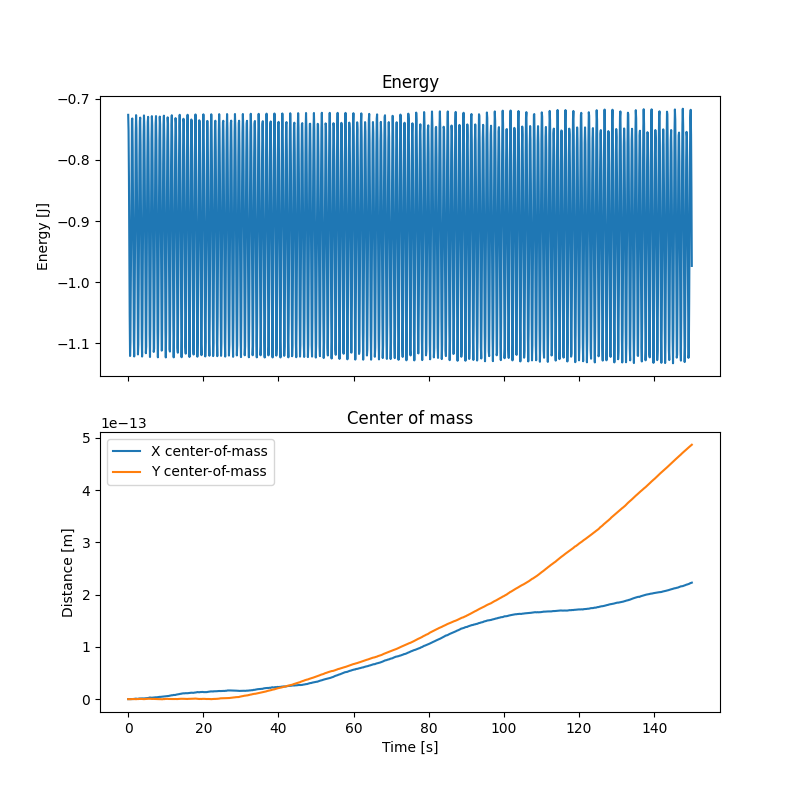

In [39]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
ax[0].plot(sol.t, energies, label='Energy')
ax[1].plot(sol.t, com_x, label='X center-of-mass')
ax[1].plot(sol.t, com_y, label='Y center-of-mass')
ax[0].set_ylabel('Energy [J]')
ax[0].set_title('Energy')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Distance [m]')
ax[1].set_title('Center of mass')
ax[1].legend();

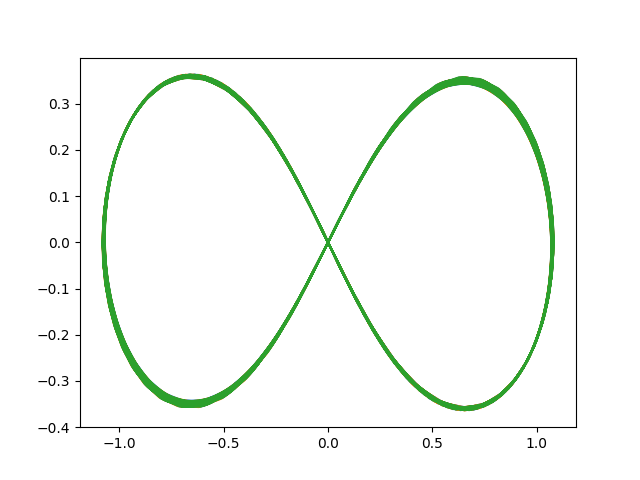

In [40]:
plt.figure()
plt.plot(sol.y[0], sol.y[1])
plt.plot(sol.y[4], sol.y[5])
plt.plot(sol.y[8], sol.y[9]);